In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import random
import re
import math
import cv2
import seaborn as sns
import scipy

In [3]:
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices), figsize=(20,20))

    for i, slice in enumerate(slices):
        axes[i].imshow(slice, cmap="gray", origin="lower")

def normalize_intensity(img_tensor, normalization="max"):
    """
    normalize non zero voxels only.
    """
    if normalization == "mean":
        mask = img_tensor.ne(0.0)
        desired = img_tensor[mask]
        mean_val, std_val = desired.mean(), desired.std()
        img_tensor = (img_tensor - mean_val) / std_val
    elif normalization == "max":
        MAX, MIN = img_tensor.max(), img_tensor.min()
        if MAX != MIN:
            img_tensor = (img_tensor - MIN) / (MAX - MIN)
        else:
            pass
    return img_tensor

def resize_img(data, scale):
    return cv2.resize(data, (scale, scale), interpolation=cv2.INTER_LINEAR)

######################## Natural Sort ###########################
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [atoi(c) for c in re.split(r'(\d+)', text)]
#################################################################


In [4]:
#compare original, DLDM, StyleGAN2
def histogram_compare(original_dir1, gen_dir2, gen_dir3):

    mode = original_dir1.split('/')[-1]
    # data load
    original_data = glob.glob(original_dir1+'/*.npy')
    # original_data = random.sample(original_data, 1000)
    gen2_data = glob.glob(gen_dir2+'/*.npy')
    # gen2_data = random.sample(gen2_data, 1000)
    gen3_data = glob.glob(gen_dir3+'/*.npy')
    # gen3_data = random.sample(gen3_data, 1000)

    bin_start = 20

    # original
    a, b = np.histogram(normalize_intensity(np.load(original_data[0])[0][0]), bins=256, range=(0, 1))
    sum_pixel = np.zeros_like(normalize_intensity(np.load(original_data[0])[0][0]))
    sum_hist = np.zeros_like(a)
    sum_edge = np.zeros_like(b)
    for image_path in original_data: 
        image = normalize_intensity(np.load(image_path)[0][0])
        sum_pixel = np.add(sum_pixel, image)
        hist, bin_edges = np.histogram(image, bins=256, range=(0, 1))
        sum_hist = np.add(sum_hist, hist)
        sum_edge = np.add(sum_edge, bin_edges)
    original_avg_hist = sum_hist/len(original_data)
    original_avg_edge = sum_edge/len(original_data)
    original_avg_pixel = sum_pixel/len(original_data)

    # gen2
    a, b = np.histogram(normalize_intensity(np.load(gen2_data[0])[0][0]), bins=256, range=(0, 1))
    sum_pixel = np.zeros_like(normalize_intensity(np.load(gen2_data[0])[0][0]))
    sum_hist = np.zeros_like(a)
    sum_edge = np.zeros_like(b)
    for image_path in gen2_data: 
        image = normalize_intensity(np.load(image_path)[0][0])
        sum_pixel = np.add(sum_pixel, image)
        hist, bin_edges = np.histogram(image, bins=256, range=(0, 1))
        sum_hist = np.add(sum_hist, hist)
        sum_edge = np.add(sum_edge, bin_edges)
    gen2_avg_hist = sum_hist/len(gen2_data)
    gen2_avg_edge = sum_edge/len(gen2_data)
    gen2_avg_pixel = sum_pixel/len(gen2_data)

    # gen3
    a, b = np.histogram(normalize_intensity(np.load(gen3_data[0])[0][0]), bins=256, range=(0, 1))
    sum_pixel = np.zeros_like(normalize_intensity(np.load(gen3_data[0])[0][0]))
    sum_hist = np.zeros_like(a)
    sum_edge = np.zeros_like(b)
    for image_path in gen3_data: 
        image = normalize_intensity(np.load(image_path)[0][0])
        sum_pixel = np.add(sum_pixel, image)
        hist, bin_edges = np.histogram(image, bins=256, range=(0, 1))
        sum_hist = np.add(sum_hist, hist)
        sum_edge = np.add(sum_edge, bin_edges)
    gen3_avg_hist = sum_hist/len(gen3_data)
    gen3_avg_edge = sum_edge/len(gen3_data)
    gen3_avg_pixel = sum_pixel/len(gen3_data)

    hist1, bin_edges1 = np.histogram(normalize_intensity(original_avg_pixel), bins=256, range=(0, 1))
    hist2, bin_edges2 = np.histogram(normalize_intensity(gen2_avg_pixel), bins=256, range=(0, 1))
    hist3, bin_edges3 = np.histogram(normalize_intensity(gen3_avg_pixel), bins=256, range=(0, 1))
    
    sns.set()
    plt.figure()
    plt.title("Average {} Histogram".format(mode))
    plt.xlabel("normalized value")
    plt.ylabel("pixel count")
    plt.xlim([0.0, 1.0])
    plt.plot(bin_edges1[bin_start:-2], hist1[bin_start:-1], label='Original')
    plt.plot(bin_edges2[bin_start:-2], hist2[bin_start:-1], label='DLDM')
    plt.plot(bin_edges3[bin_start:-2], hist3[bin_start:-1], label='StyleGAN2')
    plt.legend()

    return hist1[bin_start:-1], bin_edges1[bin_start:-2], hist2[bin_start:-1], bin_edges2[bin_start:-2], hist3[bin_start:-1], bin_edges3[bin_start:-2],

def __prepare_histogram(h1, h2):
    """Convert the histograms to scipy.ndarrays if required."""
    h1 = h1 if scipy.ndarray == type(h1) else scipy.asarray(h1)
    h2 = h2 if scipy.ndarray == type(h2) else scipy.asarray(h2)
    if h1.shape != h2.shape or h1.size != h2.size:
        raise ValueError('h1 and h2 must be of same shape and size')
    return h1, h2

def euclidean(h1, h2): # 9 us @array, 33 us @list \w 100 bins
    r"""
    Equal to Minowski distance with :math:`p=2`.
    
    See also
    --------
    minowski
    """
    h1, h2 = __prepare_histogram(h1, h2)
    return math.sqrt(scipy.sum(scipy.square(scipy.absolute(h1 - h2))))

def correlate(h1, h2): # 31 us @array, 55 us @list \w 100 bins
    r"""
    Correlation between two histograms.
    
    The histogram correlation between two histograms :math:`H` and :math:`H'` of size :math:`m`
    is defined as:
    
    .. math::
    
        d_{corr}(H, H') = 
        \frac{
            \sum_{m=1}^M (H_m-\bar{H}) \cdot (H'_m-\bar{H'})
        }{
            \sqrt{\sum_{m=1}^M (H_m-\bar{H})^2 \cdot \sum_{m=1}^M (H'_m-\bar{H'})^2}
        }
    
    with :math:`\bar{H}` and :math:`\bar{H'}` being the mean values of :math:`H` resp. :math:`H'`
        
    *Attributes:*
    - not a metric, a similarity
    
    *Attributes for normalized histograms:*
    - :math:`d(H, H')\in[-1, 1]`
    - :math:`d(H, H) = 1`
    - :math:`d(H, H') = d(H', H)`
    
    *Attributes for not-normalized histograms:*
    - :math:`d(H, H')\in[-1, 1]`
    - :math:`d(H, H) = 1`
    - :math:`d(H, H') = d(H', H)`
    
    *Attributes for not-equal histograms:*
    - not applicable
    
    Parameters
    ----------
    h1 : sequence
        The first histogram.
    h2 : sequence
        The second histogram, same bins as ``h1``.
    
    Returns
    -------
    correlate : float
        Correlation between the histograms.
        
    Notes
    -----
    Returns 0 if one of h1 or h2 contain only zeros.
    
    """
    h1, h2 = __prepare_histogram(h1, h2)
    h1m = h1 - scipy.sum(h1) / float(h1.size)
    h2m = h2 - scipy.sum(h2) / float(h2.size)
    a = scipy.sum(scipy.multiply(h1m, h2m))
    b = math.sqrt(scipy.sum(scipy.square(h1m)) * scipy.sum(scipy.square(h2m)))
    return 0 if 0 == b else a / b

def cosine(h1, h2): # 17 us @array, 42 us @list \w 100 bins
    r"""
    Cosine simmilarity.
    
    Compute the angle between the two histograms in vector space irrespective of their
    length. The cosine similarity between two histograms :math:`H` and :math:`H'` of size
    :math:`m` is defined as:
    
    .. math::
    
        d_{\cos}(H, H') = \cos\alpha = \frac{H * H'}{\|H\| \|H'\|} = \frac{\sum_{m=1}^M H_m*H'_m}{\sqrt{\sum_{m=1}^M H_m^2} * \sqrt{\sum_{m=1}^M {H'}_m^2}}
    
    
    *Attributes:*
    - not a metric, a similarity
    
    *Attributes for normalized histograms:*
    - :math:`d(H, H')\in[0, 1]`
    - :math:`d(H, H) = 1`
    - :math:`d(H, H') = d(H', H)`
    
    *Attributes for not-normalized histograms:*
    - :math:`d(H, H')\in[-1, 1]`
    - :math:`d(H, H) = 1`
    - :math:`d(H, H') = d(H', H)`
    
    *Attributes for not-equal histograms:*
    - not applicable    
        
    Parameters
    ----------
    h1 : sequence
        The first histogram.
    h2 : sequence
        The second histogram, same bins as ``h1``.
    
    Returns
    -------
    cosine : float
        Cosine simmilarity.
        
    Notes
    -----
    The resulting similarity ranges from -1 meaning exactly opposite, to 1 meaning
    exactly the same, with 0 usually indicating independence, and in-between values
    indicating intermediate similarity or dissimilarity.
    """
    h1, h2 = __prepare_histogram(h1, h2)
    return scipy.sum(h1 * h2) / math.sqrt(scipy.sum(scipy.square(h1)) * scipy.sum(scipy.square(h2)))

def __kullback_leibler(h1, h2): # 36.3 us
    """
    The actual KL implementation. @see kullback_leibler() for details.
    Expects the histograms to be of type scipy.ndarray.
    """
    result = h1.astype(scipy.float_)
    mask = h1 != 0
    result[mask] = scipy.multiply(h1[mask], scipy.log(h1[mask] / h2[mask]))
    return scipy.sum(result)

def jensen_shannon(h1, h2): # 85 us @array, 110 us @list \w 100 bins
    r"""
    Jensen-Shannon divergence.
    
    A symmetric and numerically more stable empirical extension of the Kullback-Leibler
    divergence.
    
    The Jensen Shannon divergence between two histograms :math:`H` and :math:`H'` of size
    :math:`m` is defined as:
    
    .. math::
    
        d_{JSD}(H, H') =
            \frac{1}{2} d_{KL}(H, H^*) +
            \frac{1}{2} d_{KL}(H', H^*)
    
    with :math:`H^*=\frac{1}{2}(H + H')`.
    
    *Attributes:*
    - semimetric
    
    *Attributes for normalized histograms:*
    - :math:`d(H, H')\in[0, 1]`
    - :math:`d(H, H) = 0`
    - :math:`d(H, H') = d(H', H)`
    
    *Attributes for not-normalized histograms:*
    - :math:`d(H, H')\in[0, \infty)`
    - :math:`d(H, H) = 0`
    - :math:`d(H, H') = d(H', H)`
    
    *Attributes for not-equal histograms:*
    - not applicable
    
    Parameters
    ----------
    h1 : sequence
        The first histogram.
    h2 : sequence
        The second histogram, same bins as ``h1``.
    
    Returns
    -------
    jensen_shannon : float
        Jensen-Shannon divergence.    
    """
    h1, h2 = __prepare_histogram(h1, h2)
    s = (h1 + h2) / 2.
    return __kullback_leibler(h1, s) / 2. + __kullback_leibler(h2, s) / 2.

def chi_square(h1, h2): # 23 us @array, 49 us @list \w 100
    r"""
    Chi-square distance.
    
    Measure how unlikely it is that one distribution (histogram) was drawn from the
    other. The Chi-square distance between two histograms :math:`H` and :math:`H'` of size
    :math:`m` is defined as:
    
    .. math::
    
        d_{\chi^2}(H, H') = \sum_{m=1}^M
            \frac{
                (H_m - H'_m)^2
            }{
                H_m + H'_m
            }
    
    *Attributes:*
    - semimetric
    
    *Attributes for normalized histograms:*
    - :math:`d(H, H')\in[0, 2]`
    - :math:`d(H, H) = 0`
    - :math:`d(H, H') = d(H', H)`
    
    *Attributes for not-normalized histograms:*
    - :math:`d(H, H')\in[0, \infty)`
    - :math:`d(H, H) = 0`
    - :math:`d(H, H') = d(H', H)`
    
    *Attributes for not-equal histograms:*
    - not applicable     
    
    Parameters
    ----------
    h1 : sequence
        The first histogram.
    h2 : sequence
        The second histogram.
    
    Returns
    -------
    chi_square : float
        Chi-square distance.
    """
    h1, h2 = __prepare_histogram(h1, h2)
    old_err_state = scipy.seterr(invalid='ignore') # divide through zero only occurs when the bin is zero in both histograms, in which case the division is 0/0 and leads to (and should lead to) 0
    result = scipy.square(h1 - h2) / (h1 + h2)
    scipy.seterr(**old_err_state)
    result[scipy.isnan(result)] = 0 # faster than scipy.nan_to_num, which checks for +inf and -inf also
    return scipy.sum(result)


In [5]:
def execute(seq):
    original = os.path.join('/home/yhn/Meta_synthesis/data/Severance_FID', seq)
    gen1 = os.path.join('/home/yhn/Meta_synthesis/Project/models/disentangled-latent-diffusion_expand_dim/1000_sample_epoch_202', seq)
    gen2 =os.path.join('/home/yhn/Meta_synthesis/data/stylegan2', seq)
    hist1, bin_edges1, hist2, bin_edges2, hist3, bin_edges3 = histogram_compare(original, gen1, gen2)
    print(seq)
    print('DLDM')
    print('correlation:', correlate(hist1, hist2))
    print('cosine similarity:', cosine(hist1, hist2))
    print('JSD:', jensen_shannon(hist1, hist2))
    print('chi-square distance:', chi_square(hist1, hist2))

    print('\nStyleGAN2')
    print('correlation:', correlate(hist1, hist3))
    print('cosine similarity:', cosine(hist1, hist3))
    print('JSD:', jensen_shannon(hist1, hist3))
    print('chi-square distance:', chi_square(hist1, hist3))
    print('\n\n')

# Original vs DLDM vs StyleGAN2

T1
DLDM
correlation: 0.8211320900292257
cosine similarity: 0.9759685419133435
JSD: 153.89244988872514
chi-square distance: 606.9280407812287

StyleGAN2
correlation: 0.9289824336594765
cosine similarity: 0.9894869320459014
JSD: 88.69614677707315
chi-square distance: 352.1866950265037



T2
DLDM
correlation: 0.8866634493169845
cosine similarity: 0.9777818537181422
JSD: 157.6182012999641
chi-square distance: 625.3594332542845

StyleGAN2
correlation: 0.015891129007357768
cosine similarity: 0.8550988398659093
JSD: 955.056138866031
chi-square distance: 3688.0401159044136



FLAIR
DLDM
correlation: 0.865561045497504
cosine similarity: 0.9774553024688954
JSD: 145.37507003183688
chi-square distance: 576.3888753580075

StyleGAN2
correlation: 0.07307057564261574
cosine similarity: 0.8401204506106217
JSD: 1066.8339569275342
chi-square distance: 4139.344297756953



WB
DLDM
correlation: 0.679519733253086
cosine similarity: 0.961727999767158
JSD: 206.89919220457398
chi-square distance: 814.604903402

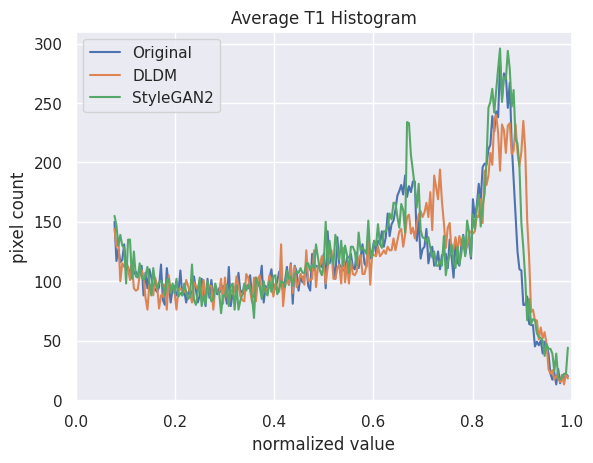

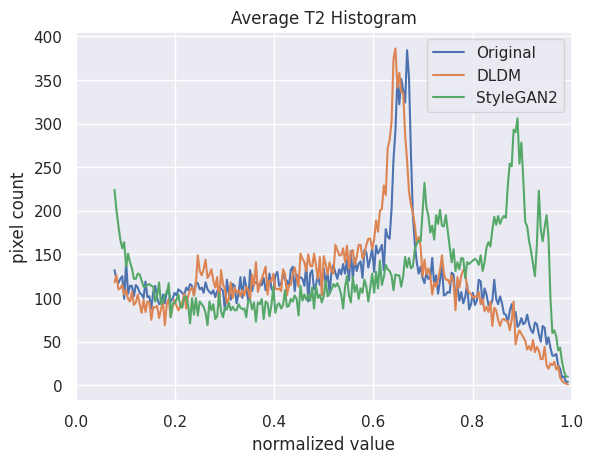

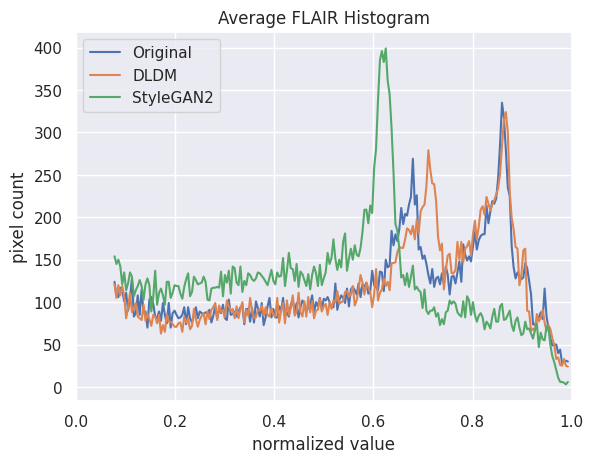

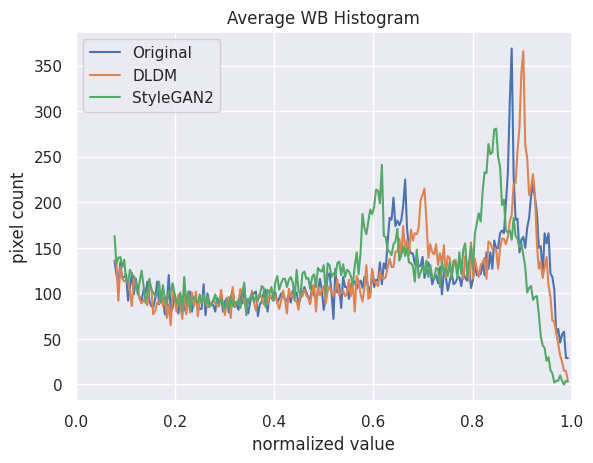

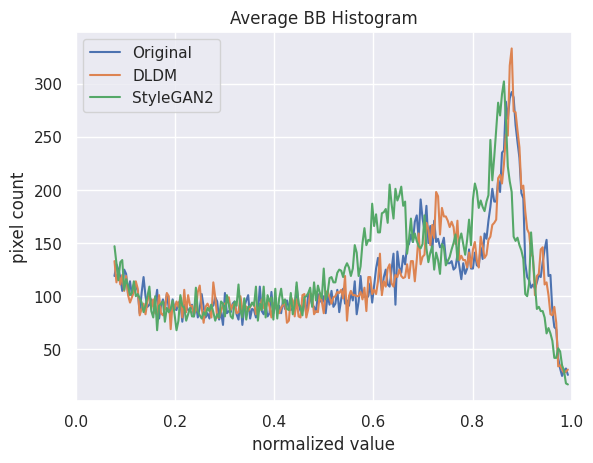

In [6]:
execute('T1')
execute('T2')
execute('FLAIR')
execute('WB')
execute('BB')

# Asan vs Severance

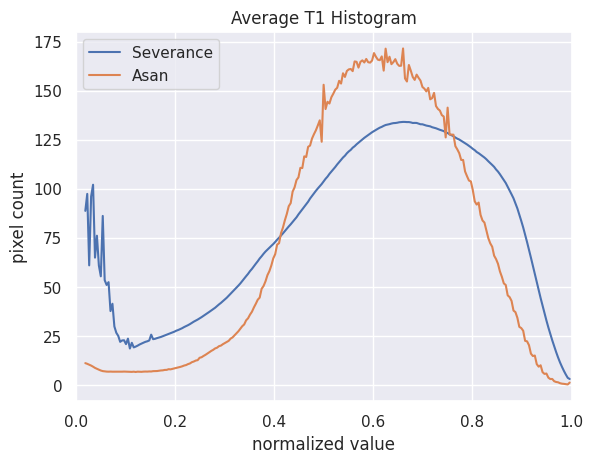

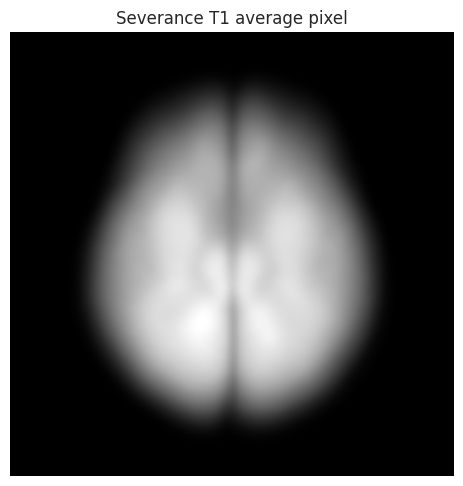

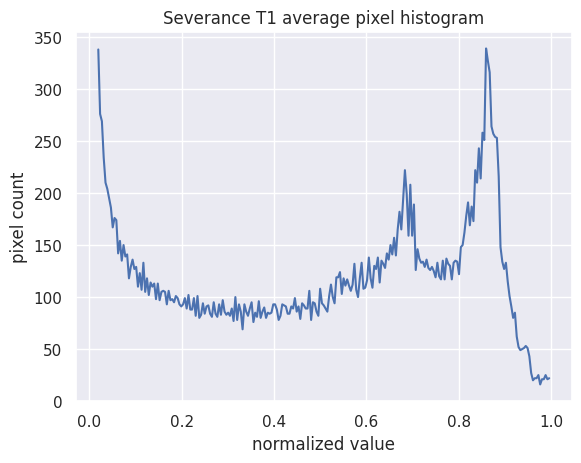

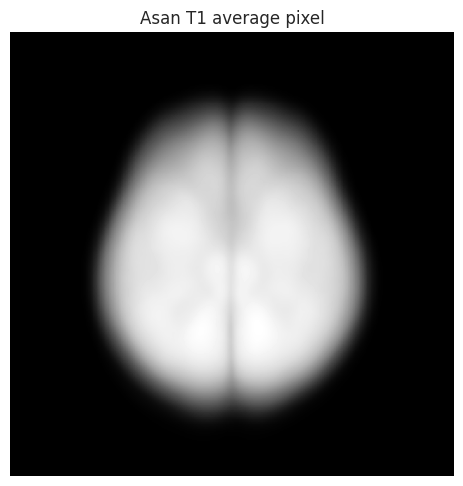

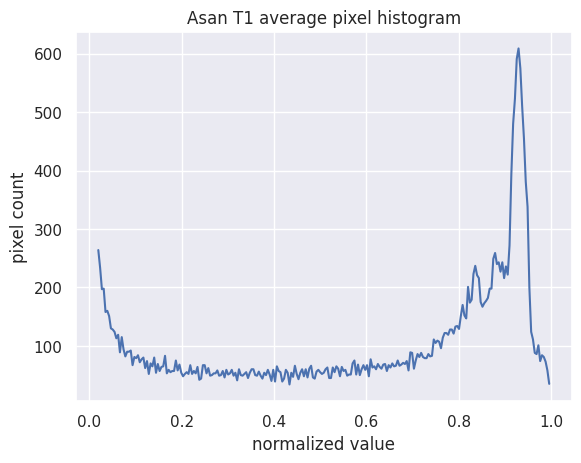

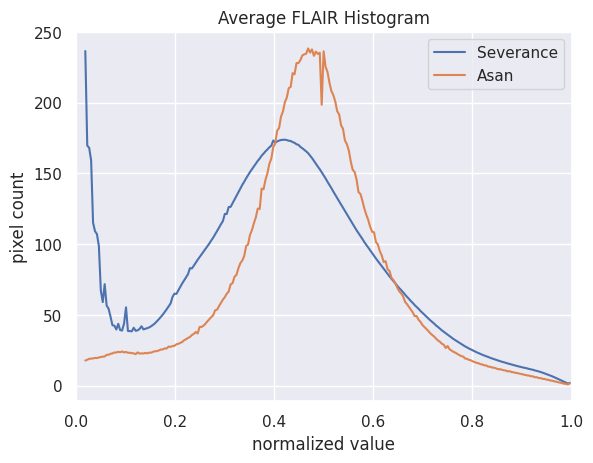

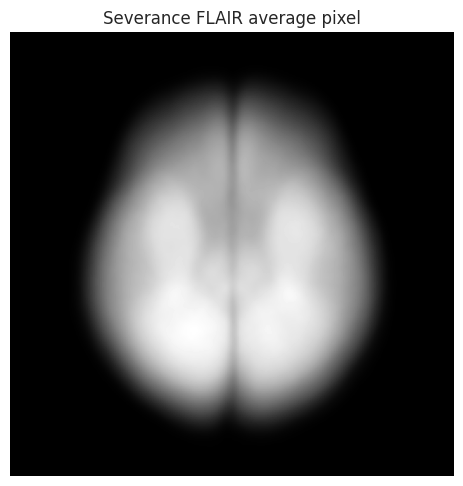

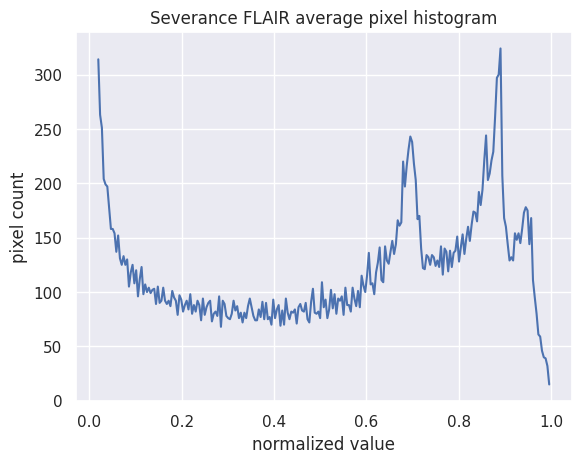

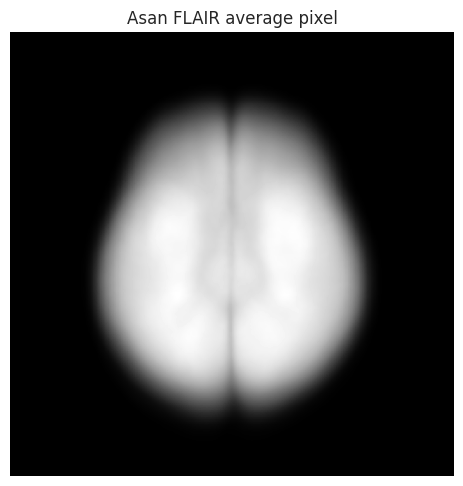

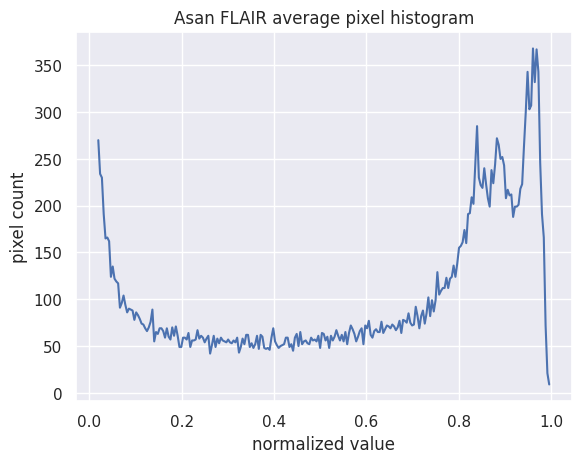

In [3]:
# severance data load
severance_t1 = glob.glob('/home/yhn/Meta_synthesis/data/Severance/T1/'+'*.npy')
asan_t1 = glob.glob('/home/yhn/Meta_synthesis/data/Asan/T1/'+'*.npy')

bin_start = 5

# severance t1
a, b = np.histogram(normalize_intensity(np.load(severance_t1[0])), bins=256, range=(0, 1))
sum_pixel = np.zeros_like(normalize_intensity(np.load(severance_t1[0])))
sum_hist = np.zeros_like(a)
sum_edge = np.zeros_like(b)
for image_path in severance_t1: 
    image = normalize_intensity(np.load(image_path))
    sum_pixel = np.add(sum_pixel, image)
    hist, bin_edges = np.histogram(image, bins=256, range=(0, 1))
    sum_hist = np.add(sum_hist, hist)
    sum_edge = np.add(sum_edge, bin_edges)
severance_avg_hist = sum_hist/len(severance_t1)
severance_avg_edge = sum_edge/len(severance_t1)
severance_t1_avg_pixel = sum_pixel/len(severance_t1)

# asan t1
a, b = np.histogram(normalize_intensity(np.load(asan_t1[0])), bins=256, range=(0, 1))
sum_pixel = np.zeros_like(normalize_intensity(np.load(asan_t1[0])))
sum_hist = np.zeros_like(a)
sum_edge = np.zeros_like(b)
for image_path in asan_t1: 
    image = normalize_intensity(np.load(image_path))
    sum_pixel = np.add(sum_pixel, image)
    hist, bin_edges = np.histogram(image, bins=256, range=(0, 1))
    sum_hist = np.add(sum_hist, hist)
    sum_edge = np.add(sum_edge, bin_edges)
asan_avg_hist = sum_hist/len(asan_t1)
asan_avg_edge = sum_edge/len(asan_t1)
asan_t1_avg_pixel = sum_pixel/len(asan_t1)

sns.set()
plt.figure()
plt.title("Average T1 Histogram")
plt.xlabel("normalized value")
plt.ylabel("pixel count")
plt.xlim([0.0, 1.0])  # <- named arguments do not work here
plt.plot(severance_avg_edge[bin_start:-1], severance_avg_hist[bin_start:], label='Severance')  # <- or here
plt.plot(asan_avg_edge[bin_start:-1], asan_avg_hist[bin_start:], label='Asan')  # <- or here
plt.legend()

plt.figure()
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)
plt.tight_layout()
plt.title("Severance T1 average pixel")
plt.imshow(severance_t1_avg_pixel, cmap='gray')
hist, bin_edges = np.histogram(normalize_intensity(severance_t1_avg_pixel), bins=256, range=(0, 1))

sns.set()
plt.figure()
plt.title("Severance T1 average pixel histogram")
plt.xlabel("normalized value")
plt.ylabel("pixel count")
plt.plot(bin_edges[bin_start:-1], hist[bin_start:])

plt.figure()
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)
plt.tight_layout()
plt.title("Asan T1 average pixel")
plt.imshow(asan_t1_avg_pixel, cmap='gray')
hist, bin_edges = np.histogram(normalize_intensity(asan_t1_avg_pixel), bins=256, range=(0, 1))

sns.set()
plt.figure()
plt.title("Asan T1 average pixel histogram")
plt.xlabel("normalized value")
plt.ylabel("pixel count")
plt.plot(bin_edges[bin_start:-1], hist[bin_start:])




asan_flair = glob.glob('/home/yhn/Meta_synthesis/data/Asan/FLAIR/'+'*.npy')
severance_flair = glob.glob('/home/yhn/Meta_synthesis/data/Severance/FLAIR/'+'*.npy')

# severance flair
a, b = np.histogram(normalize_intensity(np.load(severance_flair[0])), bins=256, range=(0, 1))
sum_pixel = np.zeros_like(normalize_intensity(np.load(severance_flair[0])))
sum_hist = np.zeros_like(a)
sum_edge = np.zeros_like(b)
for image_path in severance_flair: 
    image = normalize_intensity(np.load(image_path))
    sum_pixel = np.add(sum_pixel, image)
    hist, bin_edges = np.histogram(image, bins=256, range=(0, 1))
    sum_hist = np.add(sum_hist, hist)
    sum_edge = np.add(sum_edge, bin_edges)
severance_avg_hist = sum_hist/len(severance_flair)
severance_avg_edge = sum_edge/len(severance_flair)
severance_flair_avg_pixel = sum_pixel/len(severance_flair)

# asan flair
a, b = np.histogram(normalize_intensity(np.load(asan_flair[0])), bins=256, range=(0, 1))
sum_pixel = np.zeros_like(normalize_intensity(np.load(asan_flair[0])))
sum_hist = np.zeros_like(a)
sum_edge = np.zeros_like(b)
for image_path in asan_flair: 
    image = normalize_intensity(np.load(image_path))
    sum_pixel = np.add(sum_pixel, image)
    hist, bin_edges = np.histogram(image, bins=256, range=(0, 1))
    sum_hist = np.add(sum_hist, hist)
    sum_edge = np.add(sum_edge, bin_edges)
asan_avg_hist = sum_hist/len(asan_flair)
asan_avg_edge = sum_edge/len(asan_flair)
asan_flair_avg_pixel = sum_pixel/len(asan_flair)

sns.set()
plt.figure()
plt.title("Average FLAIR Histogram")
plt.xlabel("normalized value")
plt.ylabel("pixel count")
plt.xlim([0.0, 1.0])  # <- named arguments do not work here
plt.plot(severance_avg_edge[bin_start:-1], severance_avg_hist[bin_start:], label='Severance')  # <- or here
plt.plot(asan_avg_edge[bin_start:-1], asan_avg_hist[bin_start:], label='Asan')  # <- or here
plt.legend()

plt.figure()
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)
plt.tight_layout()
plt.title("Severance FLAIR average pixel")
plt.imshow(severance_flair_avg_pixel, cmap='gray')
hist, bin_edges = np.histogram(normalize_intensity(severance_flair_avg_pixel), bins=256, range=(0, 1))

sns.set()
plt.figure()
plt.title("Severance FLAIR average pixel histogram")
plt.xlabel("normalized value")
plt.ylabel("pixel count")
plt.plot(bin_edges[bin_start:-1], hist[bin_start:])

plt.figure()
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)
plt.tight_layout()
plt.title("Asan FLAIR average pixel")
plt.imshow(asan_flair_avg_pixel, cmap='gray')
hist, bin_edges = np.histogram(normalize_intensity(asan_flair_avg_pixel), bins=256, range=(0, 1))

sns.set()
plt.figure()
plt.title("Asan FLAIR average pixel histogram")
plt.xlabel("normalized value")
plt.ylabel("pixel count")
plt.plot(bin_edges[bin_start:-1], hist[bin_start:])